# Setup

In [1]:
import os
from typing import Literal

import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
# from torchsummary import summary
from torchvision import datasets, models

# seed for reproducibility
torch.manual_seed(42)

device = torch.device("mps" if torch.mps.is_available() else "cpu")
# device = torch.device("cpu")

root = '.'
data_dir = os.path.join(root, 'assets/asl_dataset')

# verify that the data is available
assert os.path.exists(data_dir), f"Data directory {data_dir} does not exist."

# os.getcwd()
torch.__version__

'2.6.0'

# Execution

In [2]:
from src.models import SignLanguageCNN, SignLanguageTL, SignLanguageViT
from src.trainer import SignLanguageModelTrainer
from src.preprocessing import DataPreprocessor
from src.helpers import ViTLoss, Scheduler

## Initialization

In [3]:
INPUT_SHAPE = (224, 224)
NB_CHANNELS = 3
TRAIN_RATIO, VAL_RATIO, TEST_RATIO = 0.7, 0.15, 0.15
LR = 0.001

d_model = 512
n_heads = d_model // 64
n_layers = 6
ffn_hidden_size = d_model * 4
dropout = 0.1
patch_size = 16
learnable_pos_enc = True

save_path = {
    'cnn': os.path.join(root, 'models/sign_language_cnn.pth'),
    'tl': os.path.join(root, 'models/sign_language_tl.pth'),
    'vit': os.path.join(root, 'models/sign_language_vit.pth'),
}

pretrained_model = models.resnet50
weights = models.ResNet50_Weights.DEFAULT
transform = weights.transforms()

## Data preprocessing

In [4]:
data_preprocessor = DataPreprocessor(data_dir,
                                     transform=transform,
                                     resize_shape=INPUT_SHAPE,
                                     train_ratio=TRAIN_RATIO,
                                     val_ratio=VAL_RATIO,
                                     test_ratio=TEST_RATIO)
train, val, test = data_preprocessor.preprocess()

# Print class names and sizes
classes = datasets.ImageFolder(data_dir).classes
num_classes = len(classes)
print(f"Classes: {classes}")
print(f"Train size: {len(train.dataset)}")
print(f"Validation size: {len(val.dataset)}")
print(f"Test size: {len(test.dataset)}")

Classes: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
Train size: 1760
Validation size: 377
Test size: 378


In [5]:
# train.dataset[0][0]

## Training

In [6]:
def get_trainer(model_type:Literal['cnn', 'tl', 'vit']) -> tuple[SignLanguageModelTrainer, nn.Module]:
    if model_type == 'cnn':
        model = SignLanguageCNN(num_classes)
    elif model_type == 'tl':
        model = SignLanguageTL(num_classes, pretrained_model, weights)
    elif model_type == 'vit':
        model = SignLanguageViT(num_classes,
                                d_model,
                                ffn_hidden_size,
                                INPUT_SHAPE,
                                patch_size,
                                NB_CHANNELS,
                                n_heads,
                                n_layers,
                                dropout,
                                learnable_pos_enc)
    else:
        raise ValueError(f"Model type {model_type} not implemented yet.")
    
    return SignLanguageModelTrainer(model, classes, save_path=save_path[model_type], device=device), model

In [7]:
# Train the model
epochs = 100
patience = 10
print_every = 5
label_smoothing = 0.1
betas = (0.9, 0.98)
eps = 1.0e-9
warmup_steps = 1000
save_best = True
model_type = 'vit' # 'cnn' or 'tl' or 'vit'

trainer, model = get_trainer(model_type)
train_criterion = ViTLoss(label_smoothing=label_smoothing) if model_type == 'vit' else nn.CrossEntropyLoss()  # Suitable for classification
val_criterion = ViTLoss(label_smoothing=0.0) if model_type == 'vit' else nn.CrossEntropyLoss()  # Suitable for classification
optimizer = optim.AdamW(model.parameters(), betas=betas, eps=eps) if model_type == 'vit' else optim.Adam(model.parameters(), lr=LR)
scheduler = Scheduler(optimizer, d_model, warmup_steps) if model_type == 'vit' else None

train_losses, val_losses = trainer.train(train,
                                         val,
                                         train_criterion,
                                         val_criterion,
                                         optimizer,
                                         scheduler=scheduler,
                                         epochs=epochs,
                                         patience=patience,
                                         print_every=print_every,
                                         save_best=save_best)

Epoch [  1/100] Loss: 3.58441 | Val loss: 3.58366 | LR: 0.000001 -- Best model saved
Epoch [  5/100] Loss: 3.50650 | Val loss: 3.47191 | LR: 0.000007 -- Best model saved
Epoch [ 10/100] Loss: 3.37730 | Val loss: 3.32597 | LR: 0.000014 -- Best model saved
Epoch [ 15/100] Loss: 3.27533 | Val loss: 3.23145 | LR: 0.000021 -- Best model saved
Epoch [ 20/100] Loss: 3.13913 | Val loss: 3.10978 | LR: 0.000028 -- Best model saved
Epoch [ 25/100] Loss: 3.02361 | Val loss: 2.97747 | LR: 0.000035 -- Best model saved
Epoch [ 30/100] Loss: 2.95262 | Val loss: 2.92707 | LR: 0.000042 -- Best val loss: 2.92176 | Patience: 2/10
Epoch [ 35/100] Loss: 2.89768 | Val loss: 2.84441 | LR: 0.000049 -- Best model saved
Epoch [ 40/100] Loss: 2.85748 | Val loss: 2.81048 | LR: 0.000056 -- Best val loss: 2.80592 | Patience: 2/10
Epoch [ 45/100] Loss: 2.81458 | Val loss: 2.74587 | LR: 0.000063 -- Best model saved
Epoch [ 50/100] Loss: 2.80294 | Val loss: 2.77353 | LR: 0.000070 -- Best val loss: 2.74048 | Patience: 2

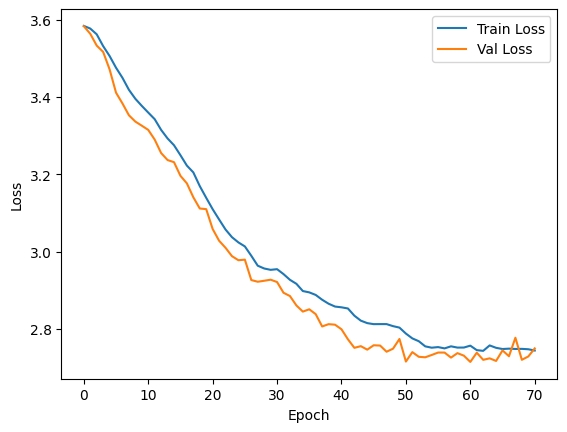

In [8]:
# Plot the training and validation losses
trainer.plot_losses(train_losses, val_losses)

## Testing

### CNN Model

In [9]:
# Evaluate
model_type = 'cnn' # 'cnn' or 'tl' or 'vt'

trainer, _ = get_trainer(model_type)
trainer.load_model(save_path[model_type])
acc, y_true, y_pred = trainer.evaluate(test, is_test=True)
acc

97.35449735449735

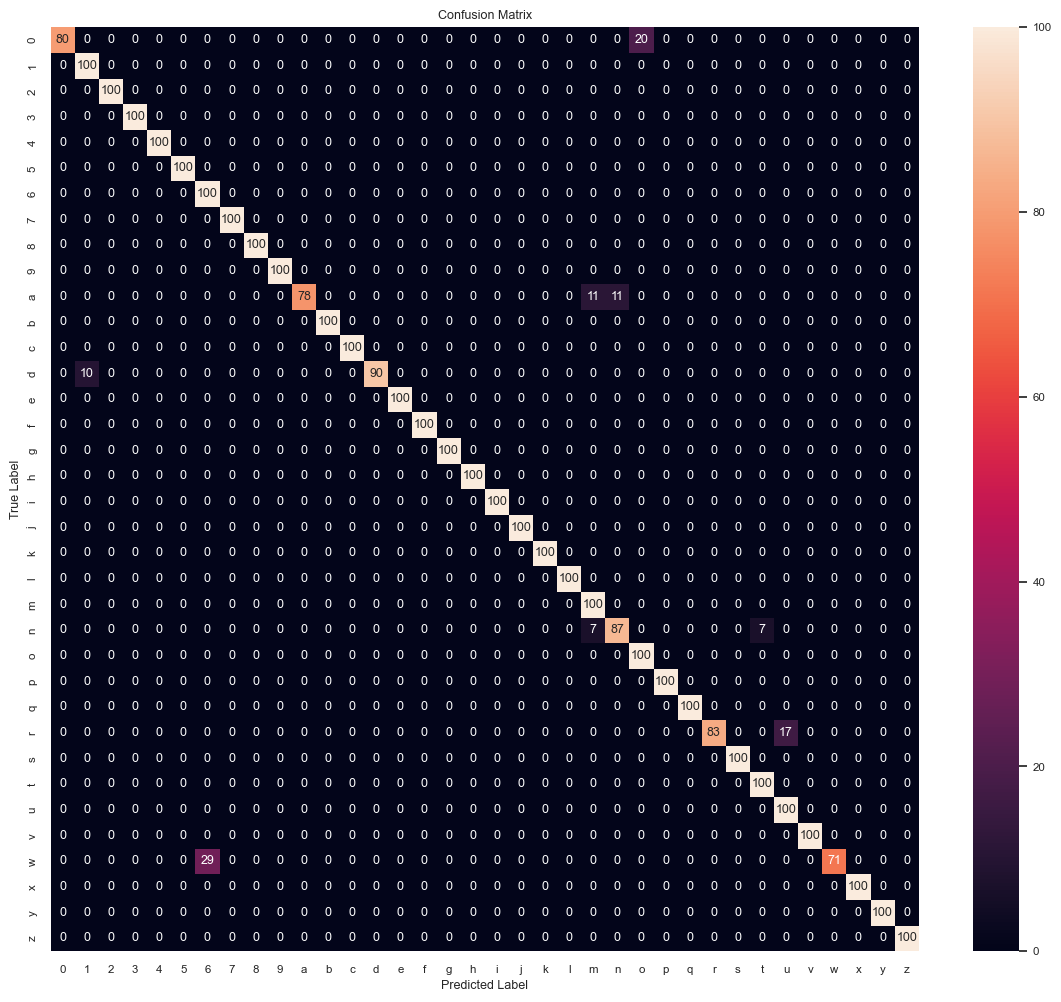

In [10]:
sns.set_theme(font_scale=0.75)
figsize = (14, 12)
trainer.plot_confusion_matrix(y_true, y_pred, classes, figsize=figsize, normalize=True, fmt='.0f')

### Transfert Learning model

In [11]:
model_type = 'tl' # 'cnn' or 'tl' or 'vt'

trainer, _ = get_trainer(model_type)
trainer.load_model(save_path[model_type])
acc, y_true, y_pred = trainer.evaluate(test, is_test=True)
acc

97.35449735449735

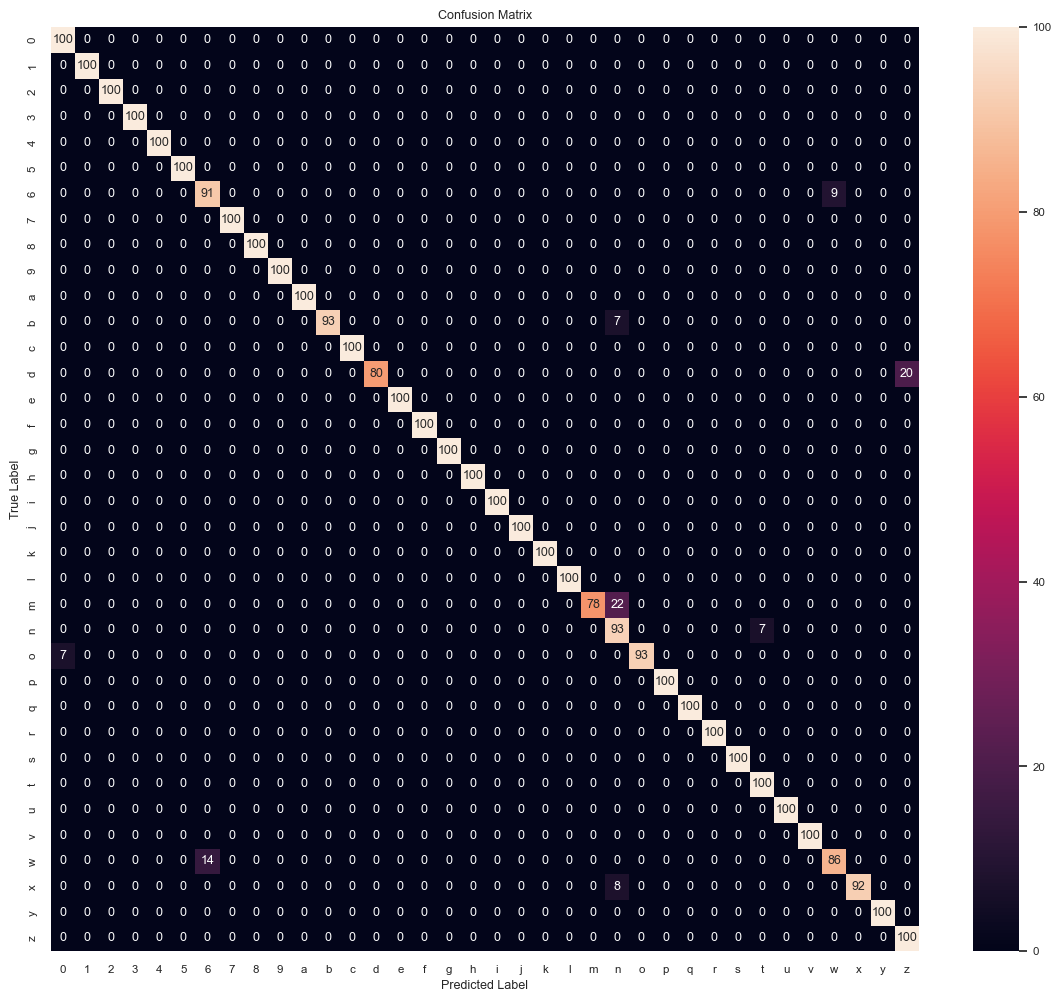

In [12]:
sns.set_theme(font_scale=0.75)
figsize = (14, 12)
trainer.plot_confusion_matrix(y_true, y_pred, classes, figsize=figsize, normalize=True, fmt='.0f')

### Vision Transformer model

In [13]:
model_type = 'vit' # 'cnn' or 'tl' or 'vit' #93.3862433862434 for 1500 warmup steps

trainer, _ = get_trainer(model_type)
trainer.load_model(save_path[model_type])
acc, y_true, y_pred = trainer.evaluate(test, is_test=True)
acc

95.23809523809524

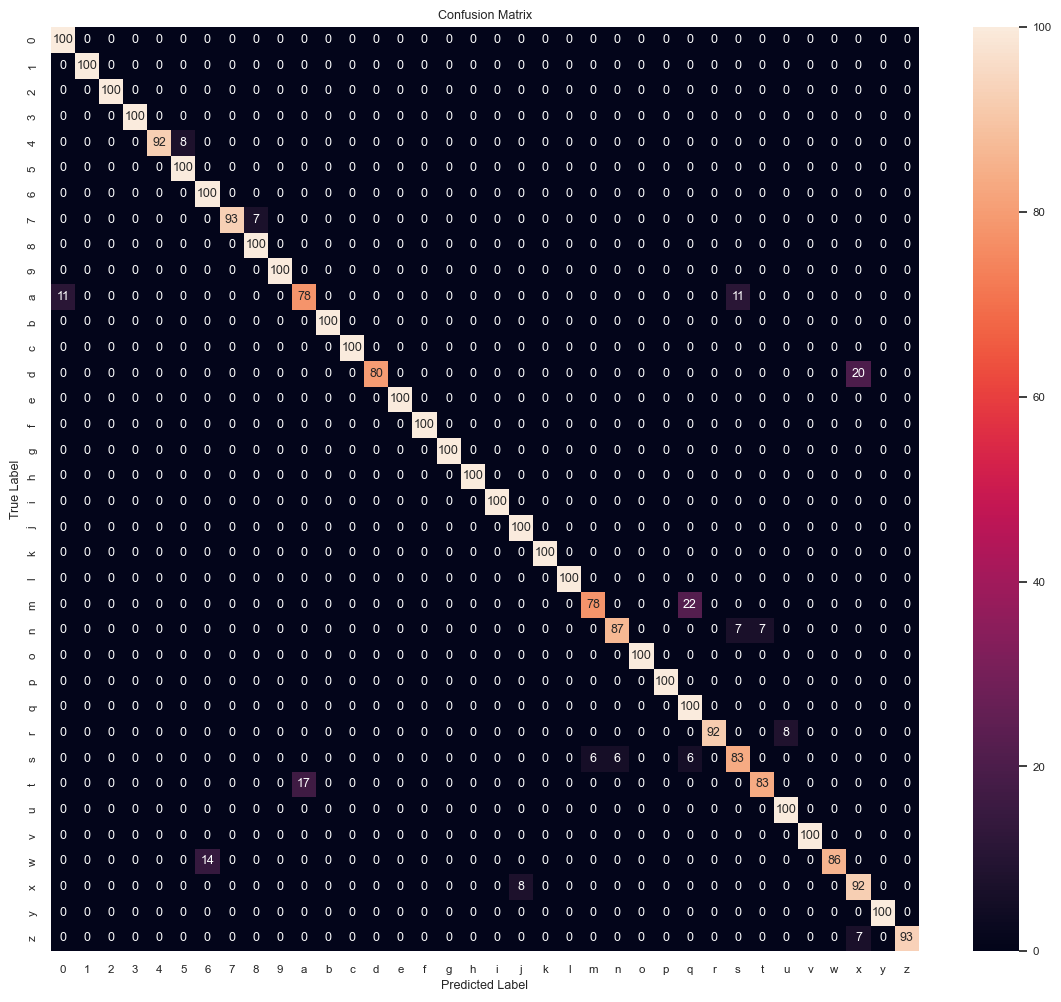

In [14]:
sns.set_theme(font_scale=0.75)
figsize = (14, 12)
trainer.plot_confusion_matrix(y_true, y_pred, classes, figsize=figsize, normalize=True, fmt='.0f')

In [15]:
from datasets import load_dataset

ds = load_dataset("Hemg/sign_language_dataset")